<a href="https://colab.research.google.com/github/afrojaakter/Surrogate-Based-Optimization/blob/main/MultiFidelityGaussianProcess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Multi-fidelity surrogate models
In many instances across computational engineering, multiple simulation codes with varying fidelities and evaluation costs are available for the same output.
High-fidelity simulations consider finer spatial/temporal resolution of the underlying physical process. Although the results are more align to reality, the computational cost is high as well. At the other end of the spectrum, we have low-fidelity simulations, which usually have coarser spatial/temporal resolutions and embed coarser physical details. However, they run much faster than their high-fidelity counterparts.



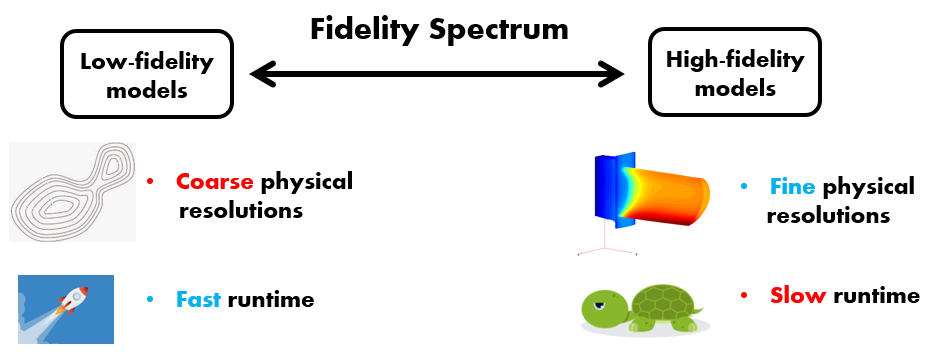

Naturally, we want our surrogate models to have the same fidelity as the high-fidelity simulations. However, generating samples purely from high-fidelity simulations is rather expensive. So how can we gain sufficient accuracy but without paying too much in the surrogate model training?
One way we can do is only generating a small number of high-fidelity samples, but at the same time generating a large number of low-fidelity samples (since they are cheap to generate). By aggregating samples from both fidelities, we may maximize the accuracy of the surrogate model while minimizing the associated training cost.
This is exactly what a multi-fidelity strategy is trying to achieve. More specifically, this strategy utilizes rich low-fidelity samples to explore the parameter space and obtain a qualitatively (but not yet quantitatively) correct description of the general trend of the approximated input-output relation. Meanwhile, this strategy leverages the available high-fidelity samples to effectively refine the low-fidelity results, thus ensuring the trained surrogate model's quantitative correctness.

####Example
Let’s work on an example of using the multi-fidelity approach to achieve the target model accuracy with only a few high-fidelity training samples.


###Gaussian Process Model with Multi-fidelity Learning


In [2]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
  sys.path.append(module_path+"\\GaussianProcess")
  

In [3]:
!pip install pyDOE

  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=23f3088e2becc1160b09309d6c1037538c0a8a18d4f0cf1c8a3349a4bc8a982a
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built pyDOE


In [4]:
# import all packages
import numpy as np

class GaussianProcess:
    """A class that trains a Gaussian Process model
    to approximate functions"""

    def __init__(self, n_restarts, opt, inital_point,
    kernel, trend, nugget):
        """Initialize a Gaussian Process model
        Input
        ------
        n_restarts (int): number of restarts of the local optimizer
        opt(dict): specify optimization parameters
                   (see scipy.optimize.minimize methods)
                   {'optimizer': str, 'jac': bool}
        inital_point (array): user-specified starting points
        kernel (string): kernel type
        nugget (float): nugget term"""

        self.n_restarts = n_restarts
        self.opt = opt
        self.init_point = inital_point
        self.kernel = kernel
        self.trend = trend
        self.nugget = nugget

    def Corr(self, X1, X2, theta):
        """Construct the correlation matrix between X1 and X2
        based on specified kernel function
        Input
        -----
        X1, X2 (2D array): shape (n_samples, n_features)
        theta (array): correlation legnths for different dimensions
        Output
        ------
        K: the correlation matrix
        """

        # Initialize correlation matrix
        K = np.zeros((X1.shape[0], X2.shape[0]))

        # Compute entries of the correlation matrix
        if self.kernel == 'Gaussian':
            # Gaussian kernel
            for i in range(X1.shape[0]):
                K[i,:] = np.exp(-np.sum(theta*(X1[i,:]-X2)**2, axis=1))

        elif self.kernel == 'Matern-3_2':
            # Matern-3/2 kernel
            for i in range(X1.shape[0]):
                comp = np.sqrt(3)*theta*np.abs(X1[i,:]-X2)
                K[i,:] = np.prod(1+comp, axis=1)*np.exp(-np.sum(comp, axis=1))

        elif self.kernel == 'Matern-5_2':
            # Matern-5/2 kernel
            for i in range(X1.shape[0]):
                comp = np.sqrt(5)*theta*np.abs(X1[i,:]-X2)
                K[i,:] = np.prod(1+comp+comp**2/3, axis=1)*np.exp(-np.sum(comp, axis=1))
        elif self.kernel == 'Cubic':
            # Cubic kernel
            for i in range(X1.shape[0]):
                comp = np.zeros_like(X2)
                diff = theta*np.abs(X1[i,:]-X2)
                # Filter values - first condition
                bool_table = (diff<1) & (diff>0.2)
                comp[bool_table] = 1.25*(1-diff[bool_table])**3
                # Filter values - second condition
                bool_table = (diff<=0.2) & (diff>=0)
                comp[bool_table] = 1-15*diff[bool_table]**2+30*diff[bool_table]**3
                # Construct kernel matrix
                K[i,:] = np.prod(comp, axis=1)

        return K

In [5]:
# import all packages
import numpy as np
import numpy.matlib
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.linalg import cho_solve
from pyDOE import lhs

class GPInterpolator(GaussianProcess):
    """A class that trains a Gaussian Process model
    to interpolate functions"""

    def __init__(self, n_restarts=20, opt={'optimizer':'L-BFGS-B',
    'jac': True}, inital_point=None, verbose=False,
    kernel='Gaussian', trend='Const', nugget=1e-10):

        # Display optimization log
        self.verbose = verbose

        super().__init__(n_restarts, opt, inital_point,
        kernel, trend, nugget)

    def Neglikelihood(self, theta):
        """Negative log-likelihood function
        Input
        -----
        theta (array): correlation legnths for different dimensions
        Output
        ------
        NegLnLike: Negative log-likelihood value
        NegLnLikeDev (optional): Derivatives of NegLnLike"""

        theta = 10**theta    # Correlation length
        n = self.X.shape[0]  # Number of training instances

        if isinstance(self.trend, str):
            if self.trend == 'Const':
                F = np.ones((n,1))
            elif self.trend == 'Linear':
                F = np.hstack((np.ones((n,1)), self.X))
            elif self.trend == 'Quadratic':
                # Problem dimensionality
                dim = self.X.shape[1]
                # Initialize F matrix
                F = np.ones((n,1))
                # Fill in linear part
                F = np.hstack((F, self.X))
                # Fill in quadratic part
                for i in range(dim):
                        F = np.hstack((F, self.X[:, [i]]*self.X[:,i:]))
        else:
            F = self.trend


        # Construct correlation matrix
        K = self.Corr(self.X, self.X, theta) + np.eye(n)*self.nugget
        L = np.linalg.cholesky(K)

        # Mean estimation
        mu = np.linalg.solve(F.T @ (cho_solve((L, True), F)),
        F.T @ (cho_solve((L, True), self.y)))
        # mu = (F.T @ (cho_solve((L, True), self.y))) / \
            # (F.T @ (cho_solve((L, True), F)))

        # Variance estimation
        SigmaSqr = (self.y-F@mu).T @ (cho_solve((L, True), self.y-F@mu)) / n

        # Compute log-likelihood
        LnDetK = 2*np.sum(np.log(np.abs(np.diag(L))))
        NegLnLike = (n/2)*np.log(SigmaSqr) + 0.5*LnDetK

        # Update attributes
        self.K, self.F, self.L, self.mu, self.SigmaSqr = K, F, L, mu, SigmaSqr

        # If derivatives are not calculated
        if self.opt['jac'] is False:

            return NegLnLike.flatten()

        # If derivatives are calculated
        else:

            # Compute derivative of log-likelihood (adjoint)
            # 1-Construct adjoint kernel matrix
            adjoint_K = 1/(2*SigmaSqr)*((cho_solve((L, True), self.y-F@mu)) @
            (cho_solve((L, True), self.y-F@mu)).T) - 0.5*(cho_solve((L, True), np.eye(n)))

            K_combo = K*adjoint_K

            # 2-Calculate derivatives
            total_sum = np.zeros(self.X.shape[1])

            for i in range(self.X.shape[1]):
                broadcast = (np.matlib.repmat(self.X[:,[i]],1,n)-
                np.matlib.repmat(self.X[:,[i]].T,n,1))**2
                total_sum[i] = np.concatenate(broadcast*K_combo).sum()

            NegLnLikeDev = np.log(10)*theta*total_sum

            return NegLnLike.flatten(), NegLnLikeDev.flatten()

    def fit(self, X, y):
        """GP model training
        Input
        -----
        X (array): shape (n_samples, n_features)
        y (array): shape (n_samples, 1)
        """

        self.X, self.y = X, y
        lb, ub = -3, 2

        # Generate random starting points (Latin Hypercube)
        lhd = lhs(self.X.shape[1], samples=self.n_restarts)

        # Scale random samples to the given bounds
        initial_points = (ub-lb)*lhd + lb

        # Expand initial points if user specified them
        if self.init_point is not None:
            initial_points = np.vstack((initial_points, self.init_point))

        # Create A Bounds instance for optimization
        bnds = Bounds(lb*np.ones(X.shape[1]),ub*np.ones(X.shape[1]))

        # Run local optimizer on all points
        opt_para = np.zeros((self.n_restarts, self.X.shape[1]))
        opt_func = np.zeros(self.n_restarts)
        for i in range(self.n_restarts):
            res = minimize(self.Neglikelihood,
            initial_points[i,:],
            jac=self.opt['jac'],
            method=self.opt['optimizer'],
            bounds=bnds)

            opt_para[i,:] = res.x
            opt_func[i] = res.fun

            # Display optimization progress in real-time
            if self.verbose == True:
                print('Iteration {}: Likelihood={} \n'
                .format(str(i+1), np.min(opt_func[:i+1])))

        # Locate the optimum results
        self.theta = opt_para[np.argmin(opt_func)]

        # Update attributes
        if self.opt['jac'] is False:
            self.NegLnlike = self.Neglikelihood(self.theta)
        else:
            self.NegLnlike, self.NegLnLikeDev = self.Neglikelihood(self.theta)

    def predict_only(self, X, y, theta):
        """Predict-only mode, with given theta value
        Input:
        -----
        X (array): shape (n_samples, n_features)
        y (array): shape (n_samples, 1)
        theta: (array): correlation legnths for different dimensions"""

        # Update training data
        self.X, self.y = X, y

        # Update attributes
        self.theta = theta

        if self.opt['jac'] is False:
            self.NegLnlike = self.Neglikelihood(self.theta)
        else:
            self.NegLnlike, self.NegLnLikeDev = self.Neglikelihood(self.theta)

    def predict(self, X_test, trend=None, cov_return=False):
        """GP model predicting
        Input
        -----
        X_test (array): test set, shape (n_samples, n_features)
        trend: trend values at test sites, shape (n_samples, n_functions)
        cov_return (bool): return/not return covariance matrix
        Output
        ------
        f: GP predictions
        SSqr: Prediction variances"""

        # Construct correlation matrix between test and train data
        k = self.Corr(self.X, X_test, 10**self.theta)

        # Mean prediction
        n = X_test.shape[0]  # Number of training instances
        dim = X_test.shape[1]  # Problem dimension

        if isinstance(self.trend, str):
            if self.trend == 'Const':
                f = self.mu + k.T @ (cho_solve((self.L, True), self.y-self.F@self.mu))
            elif self.trend == 'Linear':
                obs = np.hstack((np.ones((n,1)), X_test))
                f = obs @ self.mu + k.T @ (cho_solve((self.L, True), self.y-self.F@self.mu))
            elif self.trend == 'Quadratic':
                obs = np.ones((n,1))
                obs = np.hstack((obs, X_test))
                for i in range(dim):
                        obs = np.hstack((obs, X_test[:, [i]]*X_test[:,i:]))
                f = obs @ self.mu + k.T @ (cho_solve((self.L, True), self.y-self.F@self.mu))

        else:
            f = trend @ self.mu + k.T @ (cho_solve((self.L, True), self.y-self.F@self.mu))


        # Variance prediction
        SSqr = self.SigmaSqr*(1 - np.diag(k.T @ (cho_solve((self.L, True), k))))

        # Calculate covariance
        if cov_return is True:
            Cov = self.SigmaSqr*(self.Corr(X_test, X_test, 10**self.theta)
             - k.T @ (cho_solve((self.L, True), k)))

            # Return values
            return f.flatten(), SSqr.flatten(), Cov

        else:
            # Return values
            return f.flatten(), SSqr.flatten()

    def get_params(self, deep = False):
        return {'n_restarts':self.n_restarts, 'opt': self.opt,
        'inital_point': self.init_point, 'verbose': self.verbose,
        'kernel': self.kernel, 'trend': self.trend, 'nugget': self.nugget}

    def score(self, X_test, y_test, trend=None):
        """Calculate root mean squared error
        Input
        -----
        X_test (array): test set, shape (n_samples, n_features)
        y_test (array): test labels
        trend: trend values at test sites, shape (n_samples, n_functions)
        Output
        ------
        RMSE: the root mean square error"""

        y_pred, SSqr = self.predict(X_test, trend)
        RMSE = np.sqrt(np.mean((y_pred-y_test.flatten())**2))

        return RMSE

    def LOOCV(self):
        """Calculate leave-one-out cross-validation error
        Approximation algorithm is used speed up the calculation, see
        [Ref]Predictive approaches for choosing hyperparameters in
        Gaussian processes. Neural Comput. 13, 1103–1118
        (https://www.mitpressjournals.org/doi/abs/10.1162/08997660151134343)
        Output:
        ------
        LOO (array): Leave-one-out cross validation error at each training location
        e_CV: mean squared LOOCV error
        """

        # Calculate CV error
        Q = cho_solve((self.L, True), self.y-self.F@self.mu)
        LOO = Q.flatten()/np.diag(cho_solve((self.L, True), np.eye(self.X.shape[0])))

        e_CV = np.sqrt(np.mean(LOO**2))

        return e_CV, LOO

    def enrichment(self, criterion, candidate, diagnose=False):
        """Training sample enrichment for active learning
        Input:
        ------
        criterion (dict): learning criterion
        candidate (array): candidate sample pool, shape (n_samples, n_features)
        Output:
        -------
        target (float): the optimum target value
        index (array): the index of the selected sample
        orignal_pool (array): original sample pool
        reduced_pool (array): reduced sample pool (remove the selected sample)
        diagnostics (array): optional, the array of diagnostic results"""

        if criterion['Condition'] == 'EPE':

            # Compute cross-validation error
            LOO = self.LOOCV()[1]

            # Compute prediction variance
            pred, pred_var = self.predict(candidate)

            # Calculate bias
            bias = np.zeros(candidate.shape[0])
            for i in range(candidate.shape[0]):
                # Determine bias
                distance_sqr = np.sum((candidate[[i],:]-self.X)**2, axis=1)
                closest_index = np.argmin(distance_sqr.flatten())
                bias[i] = LOO[closest_index]**2

            # Calculate expected prediction error
            expected_error = bias + pred_var
            target = np.max(expected_error)

            # Locate promising sample
            index = np.argmax(expected_error)

            # Select promising sample
            sample = candidate[[index],:]
            reduced_candidate = np.delete(candidate, obj=index, axis=0)

            # For diagnose purposes
            diagnostics = expected_error

        elif criterion['Condition'] == 'U':

            # Make predictions
            pred, pred_var = self.predict(candidate)

            # Calculate U values
            U_values = np.abs(pred-criterion['Threshold'])/np.sqrt(pred_var)
            target = np.min(U_values)

            # Locate promising sample
            index = np.argmin(U_values)

            # Select promising sample
            sample = candidate[[index],:]
            reduced_candidate = np.delete(candidate, obj=index, axis=0)

            # For diagnose purposes
            diagnostics = U_values

        if diagnose is True:
            return target, sample, candidate, reduced_candidate, diagnostics
        else:
            return target, sample, candidate, reduced_candidate

    def realizations(self, N, X_eval):
        """Draw realizations from posterior distribution of
        the trained GP metamodeling
        Input:
        -----
        N: Number of realizations
        X_eval: Evaluate coordinates
        Output:
        -------
        samples: Generated realizations, shape (N, n_features)"""

        f, SSqr, Cov = self.predict(X_eval, cov_return=True)
        Cov = (Cov + Cov.T)/2

        samples = np.random.default_rng().multivariate_normal(mean=f, cov=Cov, size=N)

        return samples

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyDOE import lhs

%matplotlib inline


In this tutorial, we try to approximate the following function, which we assume is a high-fidelity function:

$$
y(x) = (6x-2)^2sin(12x-4), \; x \in [0, 1]
$$
In addition to the training data directly generated from the above function, we also have some training data generated from a low-fidelity approximation of the above function:

$$
y(x) = 0.5(6x-2)^2sin(12x-4)+10(x-0.5)-5, \; x \in [0, 1]
$$
Later on, we will train a multi-fidelity GP model to aggregate training data from both fidelities and the resulting GP model can accurately approximate the high-fidelity function.

In [7]:
def highfidelity(x):
  return (6*x-2)**2*np.sin(12*x-4)

def lowfidelity(x):
  return 0.5*(6*x-2)**2*np.sin(12*x-4) + 10*(x-0.5) - 5

### Generating training and test dataset
For the current multi-fidelity modeling task, we sample the design space extensively using the low-fidelity function, but only run the high-fidelity function at several of these points.

In [11]:
# Low-fidelity training dataset
X_train_LF = np.linspace(0, 1, 11).reshape(-1, 1)
y_train_LF = lowfidelity(X_train_LF)

# High-fidelity training data
X_train_HF = np.array([0.0, 0.4, 0.6, 1]).reshape(-1,1)
y_train_HF = highfidelity(X_train_HF)

# Test data
X_test = np.linspace(0, 1, 100).reshape(-1, 1)
y_test = highfidelity(X_test)

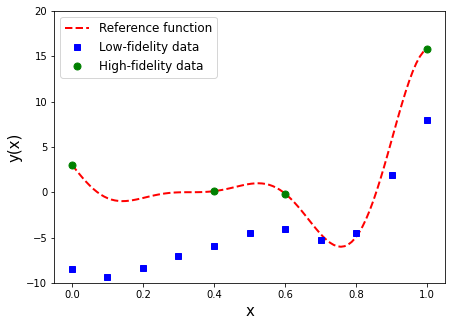

In [18]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(X_test, y_test,'r--', lw=2, label='Reference function')
ax.plot(X_train_LF, y_train_LF, 'bs',
        markersize = 6, label='Low-fidelity data')
ax.plot(X_train_HF, y_train_HF, 'go',
        markersize = 7, label='High-fidelity data')
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y(x)', fontsize=15)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-10, 20])
ax.legend(loc="upper left",prop={'size': 12});


We see the low fidelity data are not accurate but they captures the trend of the true/reference function we want to approximate. 

Now we will see by adding a few of high-fidelity data with the training data along with large number of low-fidelity data, we will be able to approximate the reference function.

### Gaussian Process model using only high-fidelity data
Let's see the accuracy of GP model trained with only high-fidelity data.


In [19]:
# Initiate a GP model
HF_GP = GPInterpolator()

# Fit a GP model on high-fidelity data
HF_GP.fit(X_train_HF, y_train_HF)

#GP predictions
HF_pred, _ = HF_GP.predict(X_test)


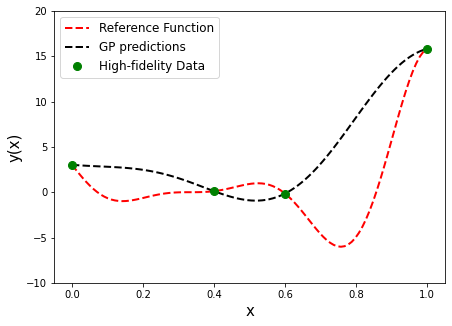

In [22]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(X_test, y_test,'r--', lw=2, label='Reference Function')
ax.plot(X_test.flatten(), HF_pred,'k--', lw=2, label='GP predictions')
ax.plot(X_train_HF, y_train_HF, 'go',
        markersize=8, label='High-fidelity Data')
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y(x)', fontsize=15)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-10, 20])
ax.legend(loc="upper left",prop={'size': 12});

The surrogate model is unable to capture the underlying function. Maybe more data will help to capture that.

Now we will combine large number of low-fidelity data with these high-fidelity data and train GP model on the new dataset.

### Multi-fidelity GP model
#### Training low-fidelity GP model
The first step in multi-fidelity modeling framework is to train a GP model based on low-fidelity training data


In [24]:
# Initiate a GP model
LF_GP = GPInterpolator()

# Fit a GP model on low-fidelity data
LF_GP.fit(X_train_LF, y_train_LF)

#### Training a multi-fidelity GP model

Next, we train a multi-fidelity GP model

In [26]:
# Calculate trend terms
LF_trend, _ = LF_GP.predict(X_train_HF)

# Initiate a GP model
multi_GP = GPInterpolator(trend=LF_trend.reshape(-1, 1))

# Fit a multi-fidelity GP model
multi_GP.fit(X_train_HF, y_train_HF)

#### Making predictions


In [27]:
# Calculte trend terms
LF_pred_trend,_ = LF_GP.predict(X_test)

# GP predictions
MF_pred, _ = multi_GP.predict(X_test, trend=LF_pred_trend.reshape(-1,1))

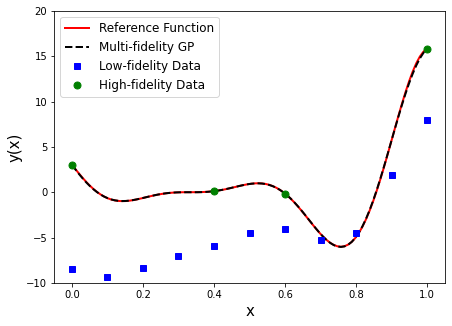

In [30]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(X_test, y_test,'r-', lw=2, label='Reference Function')
ax.plot(X_test, MF_pred,'k--', lw=2, label='Multi-fidelity GP')
ax.plot(X_train_LF, y_train_LF, 'bs',
        markersize=6, label='Low-fidelity Data')
ax.plot(X_train_HF, y_train_HF, 'go', 
        markersize=7, label='High-fidelity Data')
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y(x)', fontsize=15)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-10, 20])
ax.legend(loc="upper left",prop={'size': 12});

Now we see multi-fidelity GP model is able to capture all the trends and approximate the reference function perfectly. 

###Reference
1. [An introduction to surrogate modeling](https://towardsdatascience.com/an-introduction-to-surrogate-modeling-part-iii-beyond-basics-a60125767271)

2. [Gaussian-Process-Package](https://github.com/ShuaiGuo16/Gaussian-Process-Package)
